In [2]:
import numpy as np
import matplotlib.pyplot as plt
from errorPropPendulum import *
from scipy.special import erfc                         # Error function, to get integral of Gaussian

sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure


In [3]:
blind = True

if blind:
    blinding = np.random.uniform()
else:
    blinding = 0

experiment_by = ["anders", "christine", "Jakob", "makito"]

In [4]:
def Chauvenet(data): #Chauvenet med 1/4-del som kriterium frem for 1/2
    n = 1
    data_subset = data
    while n>0:
        n_bef = len(data_subset)
        mask = (len(data_subset) * erfc(abs(data_subset - data_subset.mean()) / data_subset.std(ddof=1))) >= 1/4
        data_subset = data_subset[mask]
        n = n_bef - len(data_subset)
        print(n)
    return data_subset, len(data)-len(data_subset)

In [5]:
#Pendulforsøg 1
#Målebåndsmålinger
L_baand_bund = np.array([191.52, 191.7, 192.35, 191.9]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_top = np.array([181.60, 181.60, 182.28, 181.6]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_sigma = 0.1 #i cm

#Lasermålinger
L_laser_bund = np.array([2.004, 2.017, 2.026]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_top = np.array([1.925, 1.918, 1.922]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_sigma = 0.001 #i m

Laser_ejenlængde = 10.3 #i cm - medregnet i længderne ovenover

#Længden mellem loddet/pendulet og gulvet blev fastholdt i løbet af forsøget til 21.3 cm, ca. 
#Approkismativt har forsøgsopstillingen ikke ændret sig undervejs

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
L_bund = np.concatenate((L_baand_bund/100, L_laser_bund - Laser_ejenlængde/100))
L_top = np.concatenate((L_baand_top/100, L_laser_top - Laser_ejenlængde/100))

print(L_bund)
print(L_top)
L_bund_ch, n_bund = Chauvenet(L_bund) #Implermentering af Chauvenet! - Fjerner ét datum
L_top_ch, n_top = Chauvenet(L_top) #Fjerner ingen data
print(L_bund_ch)
print(L_top_ch)


[1.9152 1.917  1.9235 1.919  1.901  1.914  1.923 ]
[1.816  1.816  1.8228 1.816  1.822  1.815  1.819 ]
1
0
0
[1.9152 1.917  1.9235 1.919  1.914  1.923 ]
[1.816  1.816  1.8228 1.816  1.822  1.815  1.819 ]


In [6]:

# Error antag gaussian
eL_bund = np.std(L_bund)/np.sqrt(len(L_bund))
eL_top = np.std(L_top)/np.sqrt(len(L_top))

L = (np.mean(L_top) + np.mean(L_bund)) / 2 + blinding
eL = 1/2 * np.sqrt(eL_bund**2 + eL_top**2)
print("Pendul forsøg med kort pendul")
print(f"L = {L:.3f} +- {eL:.3f}")



Pendul forsøg med kort pendul
L = 2.454 +- 0.001


In [7]:
periods = np.array([])
for person in experiment_by:
    data = np.genfromtxt(f"timedat/{person}.dat")
    times = data[:,1]
    Ts = (np.roll(times, -1) - times)[:-1] # T = [t2 - t1, t3 - t2, ..., t1 - tn]  discard the last element

    if person == "anders": # Anders measured everty 5th period
        Ts = Ts/5

    periods = np.append(periods, Ts)

#periods_ch, n_periods = Chauvenet(periods) #fjerner 1/3 af data, way to much
#print(n_periods, len(periods))

T = np.mean(periods) + blinding
eT = np.std(periods)/np.sqrt(len(periods))
print(f"T = {T:.3f} +- {eT:.3f}")

print(f"Caculated value for g = {eval_g(T, L)} +- {eval_eg(L, T, eL, eT)}")

T = 3.337 +- 0.010
Caculated value for g = 8.703355060043032 +- 0.05326627447851602


[[  1.       1.8918]
 [  2.      15.7665]
 [  3.      29.4943]
 [  4.      43.2479]
 [  5.      56.8851]
 [  6.      70.6345]
 [  7.      84.3165]
 [  8.      98.0792]
 [  9.     111.4111]
 [ 10.     125.3979]
 [ 11.     139.2739]]
First estimates of T = 2.7423281818187246 +- 0.8268460534151804
(2.7423281818187246, 0.8268460534151804)
0.10607620494919671
0.10607620494919671
Second estimates of T = 2.742328181818033 +- 0.0020227948360539857
(2.742328181818033, 0.0020227948360539857)
(2.742328181818033, 0.0020227948360539857)


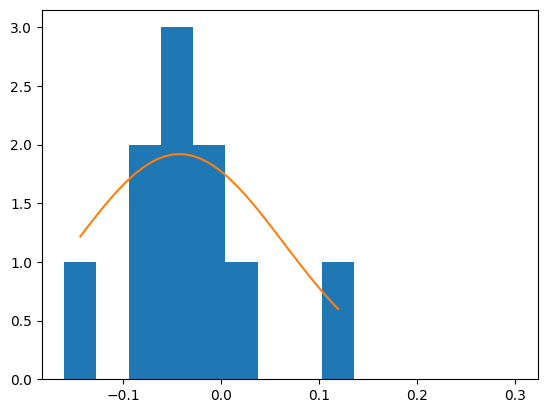

In [48]:
def linear_func(x, a, b):
    return a*x + b

def fit(fit, x, y, sy):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(fit, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, a=1, b=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    return minuit_chi2

# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def fit_pdf(x, N, mu, sigma) :
    """Gaussian"""
    return + N * binwidth * gauss_pdf(x, mu, sigma)



def fit_linear(data, sy=None):
    def linear_func(x, a, b):
        return a*x + b
    
    if not sy:
        sy = np.std(data[:,1])

    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(linear_func, data[:,0], data[:,1], sy)
    minuit_chi2 = Minuit(chi2fit, a=1, b=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    T = minuit_chi2.values["a"]
    sigmaT = minuit_chi2.errors["a"]

    return T, sigmaT

def fit_gaussian(residuals):
# Define signal PDF:
    def gauss_pdf(x, mu, sigma) :
        """Gaussian"""
        return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

    def fit_pdf(x, N, mu, sigma) :
        """Gaussian"""
        return + N * binwidth * gauss_pdf(x, mu, sigma)

    # parameters for histogram
    xmin, xmax = (-0.16, 0.30)
    Nbins = 14
    binwidth = (xmax - xmin)/Nbins
    counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))

    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

    chi2fit = Chi2Regression(fit_pdf, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, N=np.sum(y), mu=0, sigma=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

    sigma = minuit_chi2.values["sigma"]

    return sigma

def find_T_sigmaT(data):
    def linear_func(x, a, b):
        return a*x + b

    T, sigmaT = fit_linear(data)
    residuals = linear_func(data[:,0], *fit_result.values) - data[:,1]
    sigma = fit_gaussian(residuals)
    return fit_linear(data, sigma)



# parameters for histogram
xmin, xmax = (-0.16, 0.30)
Nbins = 14
binwidth = (xmax - xmin)/Nbins

data = np.genfromtxt(f"timedat/anders.dat") 
print(data)
data[:,0] *= 5
# Fitting a straight line
fit_result = fit(linear_func, data[:,0], data[:,1], sy=np.std(data[:,1]))
T = fit_result.values["a"]
sigmaT = fit_result.errors["a"]
print(f"First estimates of T = {T} +- {sigmaT}")
print(fit_linear(data))


# computing the residuals
residuals = linear_func(data[:,0], *fit_result.values) - data[:,1]

counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))

x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
plt.hist(residuals, bins=Nbins, range=(xmin, xmax) ) 

chi2fit = Chi2Regression(fit_pdf, x, y, sy)
minuit_chi2 = Minuit(chi2fit, N=np.sum(y), mu=0, sigma=1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

x_values = np.linspace(x[0], x[-1], 100)
plt.plot(x_values, fit_pdf(x_values, *minuit_chi2.values))
sigma = minuit_chi2.values["sigma"]
print(fit_gaussian(residuals))
print(sigma)
fit_result = fit(linear_func, data[:,0], data[:,1], sy=sigma)

T = fit_result.values["a"]
sigmaT = fit_result.errors["a"]
print(f"Second estimates of T = {T} +- {sigmaT}")
print(fit_linear(data, sigma))
print(find_T_sigmaT(data))

In [52]:
T_values = np.array([])
sigmaT_values = np.array([])
for person in experiment_by:
    data = np.genfromtxt(f"timedat/{person}.dat")

    if person == "anders": # Anders measured everty 5th period
        data[:,0] *= 5

    T, sigmaT = find_T_sigmaT(data)
    T_values = np.append(T_values, T)
    sigmaT_values = np.append(sigmaT_values, sigmaT)
    print(f"{person} estimated: T = {T} +- {sigmaT}")


# weighted mean of each T values
weighted_T =  np.sum(T_values/sigmaT_values**2) / np.sum(1/sigmaT_values**2) + blinding
weighted_sigmaT =  np.sum(1/sigmaT_values**2) 

#T = np.mean(periods) + blinding
#eT = np.std(periods)/np.sqrt(len(periods))
print(f"T = {weighted_T:.3f} +- {weighted_sigmaT:.3f}")

print(f"Caculated value for g = {eval_g(weighted_T, L)} +- {eval_eg(L, weighted_T, eL, weighted_sigmaT)}")

anders estimated: T = 2.742328181818033 +- 0.0020227948360539857
christine estimated: T = 2.746425806451856 +- 0.021093573140508515
Jakob estimated: T = 2.7494886290323746 +- 0.020080483073713736
makito estimated: T = 2.7442871635146693 +- 0.021093572657749773


In [9]:
#Pendulforsøg 2 - langt pendul
#Maalebaandsmaalinger
LP_baand_bund = np.array([18.327, 18.319, 18.330]) #i m - rækkefølge: Anders, Makito, Jakob
LP_baand_top = np.array([18.314, 18.312, 18.313])  #i m - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm. Kommentar: Det er nok lidt for lavt ift. præcisionen af vores måling


#Lasermaalinger
LP_laser_gulv = np.array([18.731, 18.730, 18.747]) #i m - rækkefølge: Anders, Makito, Jakob
#Kommentar: I ovenstående skal laserens ejenlængde ikke trækkes fra
LP_lod_til_gulv = np.array([39.8, 39.8, 40.3]) #i cm - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm
L_laser_sigma = 0.001 #i m

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
LP_bund = np.concatenate((LP_baand_bund, LP_laser_gulv - LP_lod_til_gulv/100))
LP_top = LP_baand_top

print(LP_bund)
LP_bund_ch, n_bund_LP = Chauvenet(LP_bund) #Implermentering af Chauvenet! - Fjerner tre data
LP_top_ch, n_top_LP = Chauvenet(LP_top) #Fjerner ingen data
print(LP_bund_ch)

# Error antag gaussian
eL_bund = np.std(LP_bund)/np.sqrt(len(LP_bund))
eL_top = np.std(LP_top)/np.sqrt(len(LP_top))

L = (np.mean(L_top) + np.mean(L_bund)) / 2 + blinding
eL = 1/2 * np.sqrt(eL_bund**2 + eL_top**2)
print("Pendul forsøg med lang pendul")
print(f"L = {L:.3f} +- {eL:.3f}")



[18.327 18.319 18.33  18.333 18.332 18.344]
2
1
0
0
[18.33  18.333 18.332]
Pendul forsøg med lang pendul
L = 2.083 +- 0.002


In [10]:

periods = np.array([])
for person in experiment_by:
    if person == "Jakob": # Jakob did not participate
        continue

    data = np.genfromtxt(f"timedat/long_{person}.dat")
    times = data[:,1]
    Ts = (np.roll(times, -1) - times)[:-1] # T = [t2 - t1, t3 - t2, ..., t1 - tn]  discard the last element

    periods = np.append(periods, Ts)

periods_ch, n_periods = Chauvenet(periods) #implermentering af Chuavenet
print(n_periods, len(periods)) #fjerner otte af 72 datapunkter


T = np.mean(periods) + blinding
eT = np.std(periods)/np.sqrt(len(periods))
print(f"T = {T:.3f} +- {eT:.3f}")

print(f"Caculated value for g = {eval_g(T, L)} +- {eval_eg(L, T, eL, eT)}")

2
2
1
1
1
1
0
8 72
T = 8.803 +- 0.019
Caculated value for g = 1.0609237272603906 +- 0.0046297802025914376


In [ ]:
# time fitting
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit = plt.figure(figsize=(16, 8))
frame1 = fig_fit.add_axes((.1,.3,.8,.6))
plt.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
#ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
plt.xlabel( "Size of company (in FTE)",fontsize=16)
plt.ylabel("Number of companies",fontsize=16)
#plt.yscale('log')
plt.legend(fontsize=16);

# Power Law fit:
# --------------
def ChiSquare_exponential(N, alpha):
    Ncompanies_est = func_Exponential(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquare_exponential, N=50000.0, alpha=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies[minFit:maxFit]) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
plt.plot(Nworkers[minFit:maxFit], func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Exponential (Chi2 = {chi2:6.1f})')

difference = func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit)/ Ncompanies[minFit:maxFit]
frame2 = fig_fit.add_axes((.1,.1,.8,.2))        
plt.plot(Nworkers[minFit:maxFit],difference,'.', color="red")
plt.grid()